tensor([-1.0000, -0.9798, -0.9596, -0.9394, -0.9192, -0.8990, -0.8788, -0.8586,
        -0.8384, -0.8182, -0.7980, -0.7778, -0.7576, -0.7374, -0.7172, -0.6970,
        -0.6768, -0.6566, -0.6364, -0.6162, -0.5960, -0.5758, -0.5556, -0.5354,
        -0.5152, -0.4949, -0.4747, -0.4545, -0.4343, -0.4141, -0.3939, -0.3737,
        -0.3535, -0.3333, -0.3131, -0.2929, -0.2727, -0.2525, -0.2323, -0.2121,
        -0.1919, -0.1717, -0.1515, -0.1313, -0.1111, -0.0909, -0.0707, -0.0505,
        -0.0303, -0.0101,  0.0101,  0.0303,  0.0505,  0.0707,  0.0909,  0.1111,
         0.1313,  0.1515,  0.1717,  0.1919,  0.2121,  0.2323,  0.2525,  0.2727,
         0.2929,  0.3131,  0.3333,  0.3535,  0.3737,  0.3939,  0.4141,  0.4343,
         0.4545,  0.4747,  0.4949,  0.5152,  0.5354,  0.5556,  0.5758,  0.5960,
         0.6162,  0.6364,  0.6566,  0.6768,  0.6970,  0.7172,  0.7374,  0.7576,
         0.7778,  0.7980,  0.8182,  0.8384,  0.8586,  0.8788,  0.8990,  0.9192,
         0.9394,  0.9596,  0.9798,  1.00

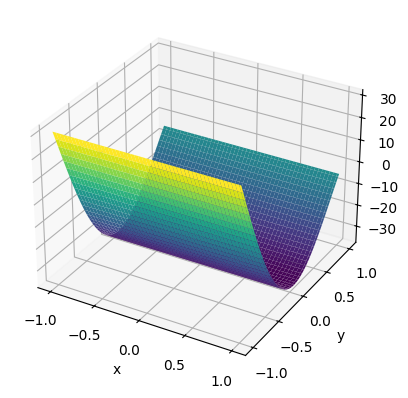

In [8]:
from qadence import (feature_map, hea, Z, QuantumModel, add, QuantumCircuit, 
                     kron, FeatureParameter, RX, RZ, VariationalParameter, RY,
                     chain, CNOT, X, Y, CRX, CRZ, I)
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
import torch
from sympy import exp

#Constant and boundary conditions
k = 3.3
d = 0.8 
xmin = -1  
xmax = 1  
ymin = -1
ymax = 1
omega1 = np.pi
omega2 = 2*np.pi

def vqc_fit(n_qubits, n_epochs, x_range, y_range, xmin, xmax, k, d):
    
    x = FeatureParameter("x")
    y = FeatureParameter("y")
    phi = VariationalParameter("phi")
    C = k**2 -omega1**2 -omega2**2
    
    block = kron(RX(0, np.sqrt(k-(d/2)**2) * x + phi), RX(1, np.sqrt(k-(d/2)**2) * y + phi))
    obs = C*exp(-x*d/2) * Z(0)
        
    circuit = QuantumCircuit(2, block)
    model = QuantumModel(circuit, observable = obs)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_fn(model, x_range, y_range, xmin, xmax, k, d)
        loss.backward()
        optimizer.step()
    # Generate predictions for the entire grid
    x_grid, y_grid = torch.meshgrid(x_range, y_range)
    u_pred = model.expectation({"x": x_grid.flatten(), "y": y_grid.flatten()}).squeeze().detach()
    u_pred = u_pred.reshape(x_grid.shape)

    return model, u_pred
    
#Once again, we need to adapt the loss function to enforce the diff. eq.

x_range = torch.linspace(-1, 1, 100)  # range of t values
y_range = torch.linspace(-1, 1, 100)  # range of t values

def loss_fn(model, x_range, y_range, xmin, xmax, k, d):
    
    x_range.requires_grad = True
    y_range.requires_grad = True
    us = model.expectation({"x": x_range, "y": y_range}).squeeze()
    
    dxs = torch.autograd.grad(us.sum(), x_range, create_graph=True)[0]
    dxs2 = torch.autograd.grad(dxs.sum(), x_range, create_graph=True)[0]
    dys = torch.autograd.grad(us.sum(), y_range, create_graph=True)[0]
    dys2 = torch.autograd.grad(dys.sum(), y_range, create_graph=True)[0]
    
    # Check if learned derivative is behaving according to diff eq.
    residual = dxs2 + dys2 + k * us + d*dxs + k * us + d*dys
    
    # Enforce boundary conditions
    bc1 = torch.abs(x_range[0] - xmin)  # x(0) = xmin
    bc2 = torch.abs(x_range[-1] - xmax)  # x(t_max) = xmax
    bc3 = torch.abs(y_range[0] - ymin)  # y(0) = ymin
    bc4 = torch.abs(y_range[-1] - ymax)  # y(t_max) = ymax
    
    boundary_penalty = 100*(bc1+bc2+bc3+bc4)
    
    # Total loss: MSE of residual and boundary conditions
    loss = torch.mean(residual**2) + boundary_penalty
    return loss


def plot_3d(x_range, y_range, u_pred):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    x, y = np.meshgrid(x_range.detach().numpy(), y_range.detach().numpy())
    u = u_pred.detach().numpy().reshape(x.shape)
    
    ax.plot_surface(x, y, u, cmap='viridis', edgecolor='none')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    plt.show()

show = True

n_qubits = 2
model, u_p = vqc_fit(n_qubits, 100, x_range, y_range, xmin, xmax, k, d)
print(x_range, y_range, u_p)
if show:
    plot_3d(x_range,y_range, u_p)
vparams = model.vparams